# Data Engineering Take-Home Assignment: Nature Conservation & Geospatial Data

## Context
Assume you have been hired as a Data Engineer for an organization focused on nature conservation. The organization is working on a project to monitor and protect natural habitats using satellite data, wildlife sensor data, and geospatial information. Your task is to design and implement a data pipeline that ingests, processes, and analyzes this data to help identify areas needing immediate conservation attention as well as build a model that provides helpful insights related our organization's interests.

## Objective

Your goal in this assessment is to showcase your curiousity and creativity to design rigorous models and derive interesting insights.  

You'll be given two tasks.

The first is a design task, in which we expect you to diagram and describe how you'd set up a process to injest this data from a live streamed source, assuming you are also paying montoring services to supply this data from scratch. Think about how you might transform and store the data efficiently for querying and analysis and feed it into your model.

The second task will require you devise interesting questions from preliminary explorations of a subset of migration data, found alongside this notebook, and construct a rigorous model to answer them. Please demonstrate all of your process using this notebook, and most importantly your outputs.




## Tasks

### 1) Design - Data Ingestion & Storage:
- **Ingestion**: Design and implement a solution to ingest data from three different sources: GeoJSON, CSV, and JSON.
- **Automation**: Ensure the pipeline can handle regular data updates (e.g., daily or hourly).
- **Storage**: Choose appropriate storage solutions for each dataset (e.g., relational database, NoSQL, cloud storage, or data lake). Provide justification for your choices.

### 2) Data Transformation & Analysis:
- **Data Parsing & Cleaning**:
  - Parse and clean the wildlife tracking data (CSV) and geospatial data (GeoJSON) to ensure consistency.
  - Ensure the data is ready for analysis by standardizing formats, removing errors, and handling missing values.

- **Exploratory Data Analysis**:
  - Investigate the data to understand key characteristics, distributions, and trends.

- **Behavioral Analysis**:
  - Identify more complex animal behaviors:
    - Determine when animals cross the boundaries of protected areas.
    - Analyze potential factors contributing to these crossings (e.g., time, weather, or environmental changes).
    - Calculate the total number of animal entries and exits from protected areas over time.

- **Advanced Insights**:
  - Identify migration paths or clustering patterns.
  - Build a predictive model to anticipate future animal movements or identify risk zones for endangered species.

### 3) Optional Bonus - Visualization/Reporting:
- Provide interactive visualizations to demonstrate your analysis, ideally within this notebook.

### Here are data sources you can use to build your analysis.

- https://storage.googleapis.com/data-science-assessment/animal_events.csv
- https://storage.googleapis.com/data-science-assessment/animals.csv
- https://storage.googleapis.com/data-science-assessment/protected_areas.json
- https://storage.googleapis.com/data-science-assessment/satellites.json

## Deliverables
#### Design component:
- A clear description and diagrams for the architecture and tools you might used, including any cloud services, databases, or libraries (if applicable). During the discussion we'll go over different scenarios.

#### Implementation:
- Code for the data pipeline that includes:
  - Data ingestion scripts or setup.
  - Transformation and processing logic.
  - Queries or outputs showcasing the results.
- (Optional) a visualization of the results.

## Data
### 1. **Animal Events - CSV** [Download link](https://storage.googleapis.com/data-science-assessment/animal_events.csv)

- Contains data on animal movement events with details like location and speed.
- **Key Columns**: `event_id`, `animal_id`, `timestamp`, `latitude`, `longitude`, `speed`.

---

### 2. **Animals - CSV** [Download link](https://storage.googleapis.com/data-science-assessment/animals.csv)

- Metadata about tracked animals, including species and conservation status.
- **Key Columns**: `animal_id`, `species`, `endangered`, `animal_type`, `preferred_landcover`.

---

### 3. **Protected Areas - GeoJSON** [Download link](https://storage.googleapis.com/data-science-assessment/protected_areas.json)

- Geospatial data representing protected areas with boundaries and metadata.
- **Key Fields**: `name`, `category`, `protected_area_id`, `geometry`.

---

### 4. **Satellite Metadata - JSON** [Download link](https://storage.googleapis.com/data-science-assessment/satellites.json)

- Metadata from satellite imagery, covering factors like cloud cover and resolution.
- **Key Fields**: `satellite_id`, `start_time`, `last_time`, `frequency`, `bounding_box`, `cloud_cover_percentage`, `resolution`.

---

## Evaluation Criteria

- **Data Engineering Skills**: How well the pipeline handles ingestion, transformation, and storage.
- **Geospatial Data Handling**: Ability to process geospatial data and perform spatial operations (e.g., joins, intersections).
- **Scalability & Efficiency**: The pipeline’s ability to handle larger datasets or more frequent updates.
- **Code Quality**: Structure, readability, and use of best practices.
- **Documentation**: Clear explanations of your approach and any assumptions made.
- **Bonus (Visualization/Reporting)**: Extra points for insightful data visualization or reporting.

## Set up

Feel free to set up this notebook using condo, or your own kernal / virtual environment. To make it easier, you can set up the notebook using this docker with the potentialy libraries you might need.

#### To start using a prepared Docker image,
- 1 navigate to this shared folder in your terminal, and then load up docker and run the docker file to pull in needed libraries

```bash
docker build -t geospatial-notebook .
docker run -p 8888:8888 -v $(pwd):/home/nobody/work geospatial-notebook
```


When the container runs, it will display a URL with a token (something like http://127.0.0.1:8888/?token=...). It will probably be something like http://127.0.0.1:8888/tree You can copy this URL into your browser, and you'll open to a Jupyter lab. Your existing notebook will be available inside the container under the work directory.

Anytime you want to work again, just run the following command to start the Docker container and access your notebooks:

```bash
docker run -p 8888:8888 -v $(pwd):/home/nobody/work geospatial-notebook
```

Please be sure your notebook runs by adding the needed dependencies to the requirements doc. I would encourage you to avoid external dependencies, like postgres setup for the implementation of your work so that the notebook work works without significant setup. You can demonstrate your knowledge of various infrastructure in your design submission.

Critiques of this assignment are also welcomed and will contribute to this score. `


In [1]:
# Libraries you may or may not need
import pandas as pd
import geopandas as gpd
import shapely
import sqlalchemy
import psycopg2
import osgeo.gdal
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import DBSCAN
from shapely.geometry import Point, Polygon, box


### load the needed datapoints


Upon quick inspection of the animal_events.csv and animals.csv columns, I will have to merge these two datasets at one point

In [2]:
animal_events= pd.read_csv('animal_events.csv')
print(animal_events.head())


  animal_id            timestamp  latitude  longitude
0      A001  2024-09-01 12:00:00   45.2284  -110.7622
1      A002  2024-09-01 12:00:00   44.5760  -110.6763
2      A003  2024-09-01 12:00:00   44.4232  -111.1061
3      A004  2024-09-01 12:00:00   37.9058  -119.7857
4      A005  2024-09-01 12:00:00   37.7896  -119.6426


Looking at the animal_events data, I am given animal_id, timestamp, latitude and longitude. So an animal did something at that time at those specific coordinates. Let's keep going.

In [3]:
animal_events['timestamp'] = pd.to_datetime(animal_events['timestamp']) # Convert to date time object

print(animal_events.info()) # Looks like no nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   animal_id  27 non-null     object        
 1   timestamp  27 non-null     datetime64[ns]
 2   latitude   27 non-null     float64       
 3   longitude  27 non-null     float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 992.0+ bytes
None


In [4]:
animal_events

,animal_id,timestamp,latitude,longitude
0,A001,2024-09-01 12:00:00,45.2284,-110.7622
1,A002,2024-09-01 12:00:00,44.5760,-110.6763
2,A003,2024-09-01 12:00:00,44.4232,-111.1061
3,A004,2024-09-01 12:00:00,37.9058,-119.7857
4,A005,2024-09-01 12:00:00,37.7896,-119.6426
5,A006,2024-09-01 12:00:00,37.8829,-119.7608
6,A007,2024-09-01 12:00:00,36.3720,-113.1627
7,A008,2024-09-01 12:00:00,36.6193,-112.3388
8,A009,2024-09-01 12:00:00,36.3388,-112.1190
9,A001,2024-09-01 13:00:00,44.3946,-110.8218


In [5]:
animals = pd.read_csv('animals.csv')
print(animals.head())


  animal_id                  common_name          scientific_name  \
0      A001                         Wolf              Canis lupus   
1      A002                        Bison              Bison bison   
2      A003                          Elk        Cervus canadensis   
3      A004  Sierra Nevada bighorn sheep  Ovis canadensis sierrae   
4      A005        Sierra Nevada red fox    Vulpes vulpes necator   

             redlist_cat megafauna  
0          Least Concern        no  
1             Vulnerable       yes  
2          Least Concern       yes  
3             Endangered        no  
4  Critically Endangered        no  


In [6]:
print(animals.info()) # No nulls


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   animal_id        9 non-null      object
 1   common_name      9 non-null      object
 2   scientific_name  9 non-null      object
 3   redlist_cat      9 non-null      object
 4   megafauna        9 non-null      object
dtypes: object(5)
memory usage: 488.0+ bytes
None


Looks like this dataset gives more info about the animal with redlist_cat indicating whether or not it is endangered

In [7]:
protected_areas = gpd.read_file('protected_areas.json')
print(protected_areas.head())


                         name       category protected_area_id  \
0   Yellowstone National Park  National Park             PA001   
1      Yosemite National Park  National Park             PA002   
2  Grand Canyon National Park  National Park             PA003   

                                            geometry  
0  POLYGON ((-110.839 44.4488, -110.7052 44.599, ...  
1  POLYGON ((-119.655 37.7244, -119.5964 37.6962,...  
2  POLYGON ((-112.1861 36.1336, -112.2156 36.2331...  


In [8]:
print(protected_areas.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   name               3 non-null      object  
 1   category           3 non-null      object  
 2   protected_area_id  3 non-null      object  
 3   geometry           3 non-null      geometry
dtypes: geometry(1), object(3)
memory usage: 224.0+ bytes
None


The protected areas have the name of the park, the category, protecred_area id and geometry.

I can combine this with the two data sets above and see whether or not the animals crossed into protected areas by using their coordinates

In [10]:
with open('satellites.json') as f:
    satellites = json.load(f)


satellites = pd.json_normalize(satellites) # Convert json to dataframe
satellites['start_time'] = pd.to_datetime(satellites['start_time']) # Convert to date time objects.
satellites['last_time'] = pd.to_datetime(satellites['last_time']) # Convert to date time objects.

print(satellites.head())



  satellite_id                start_time                 last_time  frequency  \
0       SAT001 2018-09-01 12:00:00+00:00 2024-09-10 12:00:00+00:00      daily   
1       SAT002 2004-09-01 12:00:00+00:00 2024-09-06 12:00:00+00:00  bi-weekly   
2       SAT003 2022-09-01 12:00:00+00:00 2024-09-10 12:00:00+00:00     hourly   

   cloud_cover_percentage resolution  bounding_box.xmin  bounding_box.ymin  \
0                    12.5        10m        -112.939131          42.596356   
1                    10.0       100m        -180.000000         -90.000000   
2                    10.0        20m        -124.178099          30.738207   

   bounding_box.xmax  bounding_box.ymax  
0        -107.048726          46.142424  
1         180.000000          90.000000  
2         -95.942831          51.538929  


In [11]:
print(satellites.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   satellite_id            3 non-null      object             
 1   start_time              3 non-null      datetime64[ns, UTC]
 2   last_time               3 non-null      datetime64[ns, UTC]
 3   frequency               3 non-null      object             
 4   cloud_cover_percentage  3 non-null      float64            
 5   resolution              3 non-null      object             
 6   bounding_box.xmin       3 non-null      float64            
 7   bounding_box.ymin       3 non-null      float64            
 8   bounding_box.xmax       3 non-null      float64            
 9   bounding_box.ymax       3 non-null      float64            
dtypes: datetime64[ns, UTC](2), float64(5), object(3)
memory usage: 368.0+ bytes
None


Time to combine the two datasets regarding animals.

In [12]:
tracking_animals = pd.merge(animal_events, animals, on='animal_id', how='left')
print(tracking_animals.info()) # No nulls


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   animal_id        27 non-null     object        
 1   timestamp        27 non-null     datetime64[ns]
 2   latitude         27 non-null     float64       
 3   longitude        27 non-null     float64       
 4   common_name      27 non-null     object        
 5   scientific_name  27 non-null     object        
 6   redlist_cat      27 non-null     object        
 7   megafauna        27 non-null     object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 1.8+ KB
None


In [13]:
print(tracking_animals.head())

  animal_id           timestamp  latitude  longitude  \
0      A001 2024-09-01 12:00:00   45.2284  -110.7622   
1      A002 2024-09-01 12:00:00   44.5760  -110.6763   
2      A003 2024-09-01 12:00:00   44.4232  -111.1061   
3      A004 2024-09-01 12:00:00   37.9058  -119.7857   
4      A005 2024-09-01 12:00:00   37.7896  -119.6426   

                   common_name          scientific_name  \
0                         Wolf              Canis lupus   
1                        Bison              Bison bison   
2                          Elk        Cervus canadensis   
3  Sierra Nevada bighorn sheep  Ovis canadensis sierrae   
4        Sierra Nevada red fox    Vulpes vulpes necator   

             redlist_cat megafauna  
0          Least Concern        no  
1             Vulnerable       yes  
2          Least Concern       yes  
3             Endangered        no  
4  Critically Endangered        no  


I want to now adjust the latitude and longitudes so that we can eventually see whether or not they overlap with the protected_areas' coordinates.

In [14]:
tracking_animals['animal_coordinates'] = tracking_animals.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
tracking_gdf = gpd.GeoDataFrame(tracking_animals, geometry='animal_coordinates')

print(tracking_gdf.head())

  animal_id           timestamp  latitude  longitude  \
0      A001 2024-09-01 12:00:00   45.2284  -110.7622   
1      A002 2024-09-01 12:00:00   44.5760  -110.6763   
2      A003 2024-09-01 12:00:00   44.4232  -111.1061   
3      A004 2024-09-01 12:00:00   37.9058  -119.7857   
4      A005 2024-09-01 12:00:00   37.7896  -119.6426   

                   common_name          scientific_name  \
0                         Wolf              Canis lupus   
1                        Bison              Bison bison   
2                          Elk        Cervus canadensis   
3  Sierra Nevada bighorn sheep  Ovis canadensis sierrae   
4        Sierra Nevada red fox    Vulpes vulpes necator   

             redlist_cat megafauna         animal_coordinates  
0          Least Concern        no  POINT (-110.7622 45.2284)  
1             Vulnerable       yes   POINT (-110.6763 44.576)  
2          Least Concern       yes  POINT (-111.1061 44.4232)  
3             Endangered        no  POINT (-119.7857

Now that I have the coordinates in point form, I can merge with the protected_areas and see whether or not animals are within the designated areas

In [15]:

def check_protected_area_for_group(group, protected_areas_gdf):
    protected_area_columns = []  # List to store information about each row

    for i, row in group.iterrows():
        point_coords = row['animal_coordinates']  # The animal's current location
        point = Point(point_coords)  # Convert coordinates to Shapely Point object

        # Check if the point is inside any polygon from protected_areas_gdf
        is_inside = False
        area_info = {}

        for j, area_row in protected_areas_gdf.iterrows():
            polygon = area_row['geometry']  # Polygon representing the protected area

            if polygon.contains(point):
                is_inside = True
                area_info = area_row.copy()  # Copy the protected area info
                area_info['status'] = 'Inside'
                break

        if not is_inside:
            area_info = pd.Series([None] * len(protected_areas_gdf.columns), index=protected_areas_gdf.columns)
            area_info['status'] = 'Outside'

        protected_area_columns.append(area_info)  # Add the current row's info to the list

    # Return the result as a DataFrame with a prefix for the column names to avoid mishaps.
    return pd.DataFrame(protected_area_columns).add_prefix('protected_area_')

# Apply the function to each group of animals, sorting by timestamp
tracking_gdf = tracking_gdf.sort_values(by=['animal_id', 'timestamp'])  # Sort by animal_id and timestamp
tracking_gdf_grouped = tracking_gdf.groupby('animal_id').apply(lambda group: check_protected_area_for_group(group, protected_areas))

# Concatenate the results back to the original tracking_gdf
tracking_gdf = pd.concat([tracking_gdf.reset_index(drop=True), tracking_gdf_grouped.reset_index(drop=True)], axis=1)


In [16]:

tracking_gdf

,animal_id,timestamp,latitude,longitude,common_name,scientific_name,redlist_cat,megafauna,animal_coordinates,protected_area_name,protected_area_category,protected_area_protected_area_id,protected_area_geometry,protected_area_status
0,A001,2024-09-01 12:00:00,45.2284,-110.7622,Wolf,Canis lupus,Least Concern,no,POINT (-110.7622 45.2284),None,None,None,None,Outside
1,A001,2024-09-01 13:00:00,44.3946,-110.8218,Wolf,Canis lupus,Least Concern,no,POINT (-110.8218 44.3946),None,None,None,None,Outside
2,A001,2024-09-01 14:00:00,44.4246,-110.1118,Wolf,Canis lupus,Least Concern,no,POINT (-110.1118 44.4246),None,None,None,None,Outside
3,A002,2024-09-01 12:00:00,44.5760,-110.6763,Bison,Bison bison,Vulnerable,yes,POINT (-110.6763 44.576),Yellowstone National Park,National Park,PA001,"POLYGON ((-110.839 44.4488, -110.7052 44.599, ...",Inside
4,A002,2024-09-01 13:00:00,44.5361,-110.7078,Bison,Bison bison,Vulnerable,yes,POINT (-110.7078 44.5361),Yellowstone National Park,National Park,PA001,"POLYGON ((-110.839 44.4488, -110.7052 44.599, ...",Inside
5,A002,2024-09-01 14:00:00,44.2221,-110.8182,Bison,Bison bison,Vulnerable,yes,POINT (-110.8182 44.2221),None,None,None,None,Outside
6,A003,2024-09-01 12:00:00,44.4232,-111.1061,Elk,Cervus canadensis,Least Concern,yes,POINT (-111.1061 44.4232),None,None,None,None,Outside
7,A003,2024-09-01 13:00:00,44.5472,-110.7893,Elk,Cervus canadensis,Least Concern,yes,POINT (-110.7893 44.5472),None,None,None,None,Outside
8,A003,2024-09-01 14:00:00,44.5519,-110.9812,Elk,Cervus canadensis,Least Concern,yes,POINT (-110.9812 44.5519),None,None,None,None,Outside
9,A004,2024-09-01 12:00:00,37.9058,-119.7857,Sierra Nevada bighorn sheep,Ovis canadensis sierrae,Endangered,no,POINT (-119.7857 37.9058),None,None,None,None,Outside


Now to focus on the satellites.json data

In [17]:
satellites['geometry'] = satellites.apply(lambda row: box(row['bounding_box.xmin'],
                                                               row['bounding_box.ymin'],
                                                               row['bounding_box.xmax'],
                                                               row['bounding_box.ymax']), axis=1)
satellites_gdf = gpd.GeoDataFrame(satellites, geometry='geometry')

satellites_gdf

,satellite_id,start_time,last_time,frequency,cloud_cover_percentage,resolution,bounding_box.xmin,bounding_box.ymin,bounding_box.xmax,bounding_box.ymax,geometry
0,SAT001,2018-09-01 12:00:00+00:00,2024-09-10 12:00:00+00:00,daily,12.5,10m,-112.939131,42.596356,-107.048726,46.142424,"POLYGON ((-107.04873 42.59636, -107.04873 46.1..."
1,SAT002,2004-09-01 12:00:00+00:00,2024-09-06 12:00:00+00:00,bi-weekly,10.0,100m,-180.000000,-90.000000,180.000000,90.000000,"POLYGON ((180 -90, 180 90, -180 90, -180 -90, ..."
2,SAT003,2022-09-01 12:00:00+00:00,2024-09-10 12:00:00+00:00,hourly,10.0,20m,-124.178099,30.738207,-95.942831,51.538929,"POLYGON ((-95.94283 30.73821, -95.94283 51.538..."


Now I want to see whether or not the time stamps in the animal data fall in the range of the satellite data. By coming up with a filter of some sorts, I can remove any potentially flawed data. It is important to note that the only nulls in the data are those where animals have not crossed into protected areas.

In [18]:
tracking_satellites_gdf = gpd.sjoin(tracking_gdf, satellites_gdf, how='left', predicate='within')
tracking_satellites_gdf['timestamp'] = tracking_satellites_gdf['timestamp'].dt.tz_localize('UTC')

tracking_satellites_gdf = tracking_satellites_gdf[
    (tracking_satellites_gdf['timestamp'] >= tracking_satellites_gdf['start_time']) &
    (tracking_satellites_gdf['timestamp'] <= tracking_satellites_gdf['last_time'])
]

tracking_satellites_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 63 entries, 0 to 26
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype              
---  ------                            --------------  -----              
 0   animal_id                         63 non-null     object             
 1   timestamp                         63 non-null     datetime64[ns, UTC]
 2   latitude                          63 non-null     float64            
 3   longitude                         63 non-null     float64            
 4   common_name                       63 non-null     object             
 5   scientific_name                   63 non-null     object             
 6   redlist_cat                       63 non-null     object             
 7   megafauna                         63 non-null     object             
 8   animal_coordinates                63 non-null     geometry           
 9   protected_area_name               10 non-null     object        

Now that the data has been pre-processed, it is time to perform Exploratory Data Analysis.

In [19]:
print(tracking_satellites_gdf.describe())  # Summary statistics


        latitude   longitude  index_right  cloud_cover_percentage  \
count  63.000000   63.000000    63.000000               63.000000   
mean   40.325624 -113.788059     1.285714               10.357143   
std     3.722974    3.826304     0.705476                0.881845   
min    36.226100 -119.785700     0.000000               10.000000   
25%    36.645200 -119.580400     1.000000               10.000000   
50%    37.868100 -112.230800     1.000000               10.000000   
75%    44.424600 -110.818200     2.000000               10.000000   
max    45.228400 -110.111800     2.000000               12.500000   

       bounding_box.xmin  bounding_box.ymin  bounding_box.xmax  \
count          63.000000          63.000000          63.000000   
mean         -146.496204         -19.312718          20.731826   
std            29.482349          61.832611         139.086458   
min          -180.000000         -90.000000        -107.048726   
25%          -180.000000         -90.000000     

Let's also split the time stamps into month, day and year. Maybe we can get some insight into seasonal behavior, if any. The nature of the dataset is that it only has data from September. However, I am setting this up as if there would be more data to come that would cover the other months as well.

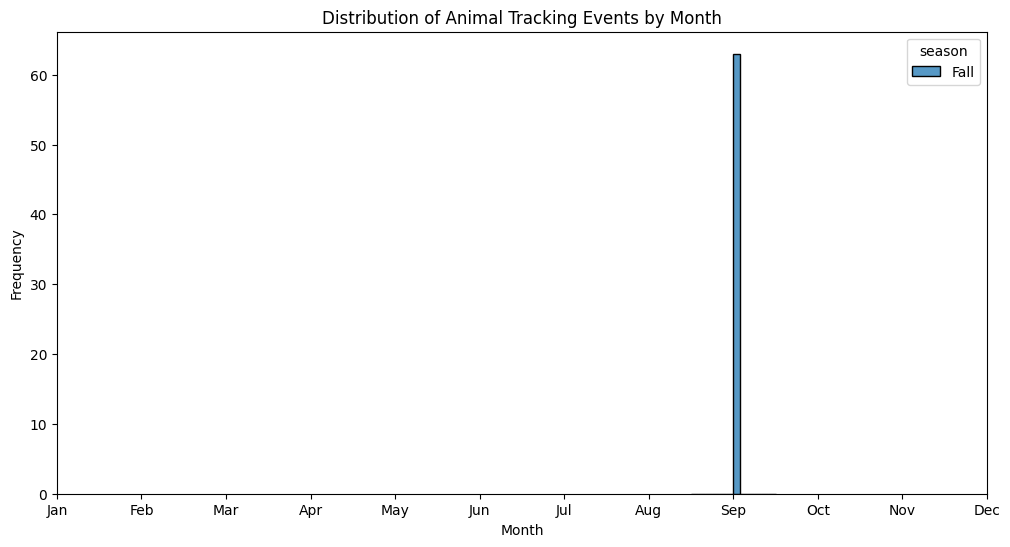

In [20]:
# Split the timestamp into year, month, and day.
tracking_satellites_gdf['year'] = tracking_satellites_gdf['timestamp'].dt.year
tracking_satellites_gdf['month'] = tracking_satellites_gdf['timestamp'].dt.month
tracking_satellites_gdf['day'] = tracking_satellites_gdf['timestamp'].dt.day
tracking_satellites_gdf['hour'] = tracking_satellites_gdf['timestamp'].dt.hour  # Extracting hour

# Adding a season column
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

tracking_satellites_gdf['season'] = tracking_satellites_gdf['month'].apply(get_season)

# Distribution of animal tracking by year and month
plt.figure(figsize=(12, 6))
sns.histplot(data=tracking_satellites_gdf, x='month', hue='season', multiple='stack', bins=12)
plt.title('Distribution of Animal Tracking Events by Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


My first question is, where are the animals usually seen? Are they scattered or in specific regions?

cluster
8     10
3      9
7      6
13     4
0      3
2      3
4      3
5      3
6      3
1      3
16     2
15     2
14     2
9      2
12     2
11     2
10     2
17     2
Name: count, dtype: int64


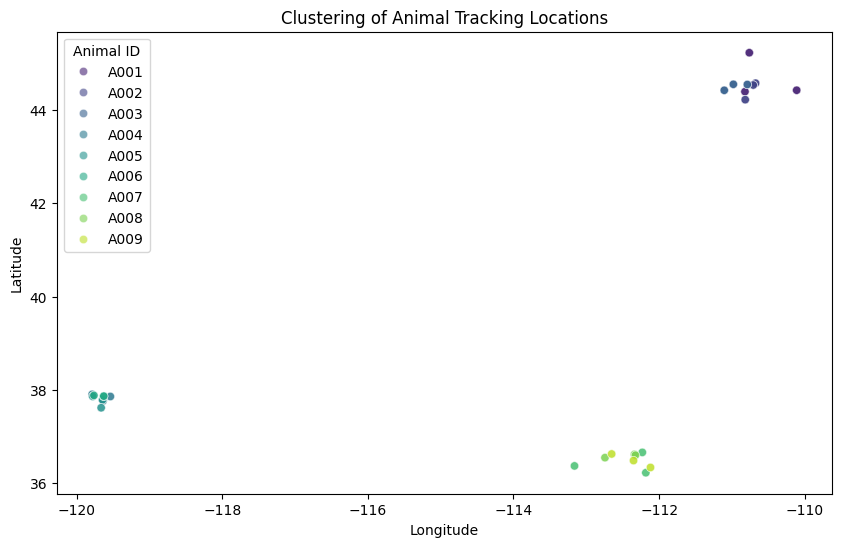

In [21]:

# Convert latitude and longitude to radians
coords = np.radians(tracking_satellites_gdf[['latitude', 'longitude']])

kms_per_radian = 6371.0088  # Earth's radius in kilometers
eps_default = 10
eps_value = eps_default / kms_per_radian  # eps_default per radian

# Apply DBSCAN clustering
db = DBSCAN(eps=eps_value, min_samples=2, metric='haversine').fit(coords)
tracking_satellites_gdf['cluster'] = db.labels_

# Count the number of occurrences of each cluster
cluster_counts = tracking_satellites_gdf['cluster'].value_counts()
print(cluster_counts)

# Visualize clusters
plt.figure(figsize=(10, 6))

# Scatter plot without cluster ID in the legend
sns.scatterplot(data=tracking_satellites_gdf, x='longitude', y='latitude', hue='animal_id', palette='viridis', alpha=0.6)

# Move legend to the top left corner and remove cluster from legend
plt.legend(title='Animal ID', loc='upper left')

# Add title and labels
plt.title('Clustering of Animal Tracking Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


Looks like there are 3 main clusters/regions where the animals are located. Let's also plot the protected areas and examine observe animal movement.

<ipython-input-22-fbac8d5f3d99>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_animals)  # Using a colormap with distinct colors
<ipython-input-22-fbac8d5f3d99>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = ListedColormap(plt.cm.get_cmap('tab20', n_clusters).colors)


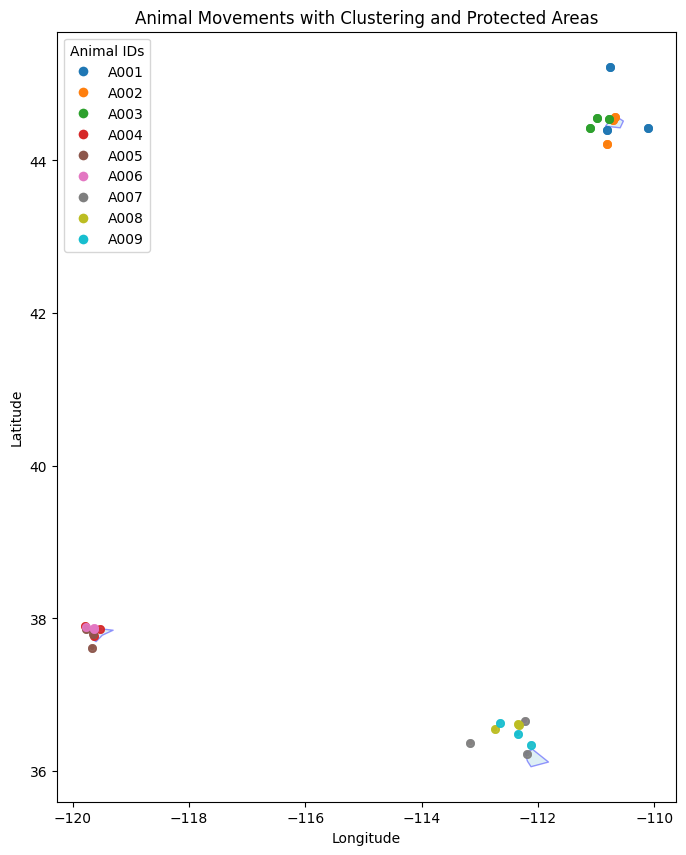

In [22]:

# Generating color map for animal IDs
unique_animals = tracking_satellites_gdf['animal_id'].unique()
num_animals = len(unique_animals)
colors = plt.cm.get_cmap('tab10', num_animals)  # Using a colormap with distinct colors

# Map animal IDs to colors
animal_color_map = {animal: colors(i) for i, animal in enumerate(unique_animals)}

# Plot clustered points
fig, ax = plt.subplots(figsize=(10, 10))

# Set up color map for clusters (ignoring noise labeled as -1)
n_clusters = tracking_satellites_gdf['cluster'].nunique()
cmap = ListedColormap(plt.cm.get_cmap('tab20', n_clusters).colors)

tracking_satellites_gdf.plot(column='cluster', cmap=cmap, ax=ax, markersize=5, legend=False)

# Also plot the protected areas.
protected_areas.plot(ax=ax, facecolor='lightblue', edgecolor='blue', alpha=0.4)

# OPlot animal IDs with color coding
for idx, row in tracking_satellites_gdf.iterrows():
    ax.scatter(row['longitude'], row['latitude'],
               color=animal_color_map[row['animal_id']],
               marker='o', s=30, alpha=0.7)


plt.title('Animal Movements with Clustering and Protected Areas')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=animal_color_map[animal], markersize=8)
           for animal in unique_animals]
plt.legend(handles, unique_animals, title="Animal IDs", loc='upper left')

plt.show()


Just like how there are 3 main clusters, there are protected areas in those areas as well. To gain further insights, you can generate similar plots for varying times for each animal id. I am also going to drop a few columns because I don't think they are needed and or are redundant. Examples include timestamp, scientific_name and cluster

In [23]:
columns_to_drop = ['timestamp', 'scientific_name', 'cluster', 'season', 'year','month', 'day'] # Dropping season because in this case, it is all the same.

tracking_satellites_gdf = tracking_satellites_gdf.drop(columns=columns_to_drop)
tracking_satellites_gdf.sort_values(by=['animal_id', 'hour'], ascending=[True, True], inplace=True)
print(tracking_satellites_gdf.head())





  animal_id  latitude  longitude common_name    redlist_cat megafauna  \
0      A001   45.2284  -110.7622        Wolf  Least Concern        no   
0      A001   45.2284  -110.7622        Wolf  Least Concern        no   
0      A001   45.2284  -110.7622        Wolf  Least Concern        no   
1      A001   44.3946  -110.8218        Wolf  Least Concern        no   
1      A001   44.3946  -110.8218        Wolf  Least Concern        no   

          animal_coordinates protected_area_name protected_area_category  \
0  POINT (-110.7622 45.2284)                None                    None   
0  POINT (-110.7622 45.2284)                None                    None   
0  POINT (-110.7622 45.2284)                None                    None   
1  POINT (-110.8218 44.3946)                None                    None   
1  POINT (-110.8218 44.3946)                None                    None   

  protected_area_protected_area_id  ...                start_time  \
0                             None 

In [24]:
tracking_satellites_gdf

,animal_id,latitude,longitude,common_name,redlist_cat,megafauna,animal_coordinates,protected_area_name,protected_area_category,protected_area_protected_area_id,...,start_time,last_time,frequency,cloud_cover_percentage,resolution,bounding_box.xmin,bounding_box.ymin,bounding_box.xmax,bounding_box.ymax,hour
0,A001,45.2284,-110.7622,Wolf,Least Concern,no,POINT (-110.7622 45.2284),None,None,None,...,2018-09-01 12:00:00+00:00,2024-09-10 12:00:00+00:00,daily,12.5,10m,-112.939131,42.596356,-107.048726,46.142424,12
0,A001,45.2284,-110.7622,Wolf,Least Concern,no,POINT (-110.7622 45.2284),None,None,None,...,2004-09-01 12:00:00+00:00,2024-09-06 12:00:00+00:00,bi-weekly,10.0,100m,-180.000000,-90.000000,180.000000,90.000000,12
0,A001,45.2284,-110.7622,Wolf,Least Concern,no,POINT (-110.7622 45.2284),None,None,None,...,2022-09-01 12:00:00+00:00,2024-09-10 12:00:00+00:00,hourly,10.0,20m,-124.178099,30.738207,-95.942831,51.538929,12
1,A001,44.3946,-110.8218,Wolf,Least Concern,no,POINT (-110.8218 44.3946),None,None,None,...,2018-09-01 12:00:00+00:00,2024-09-10 12:00:00+00:00,daily,12.5,10m,-112.939131,42.596356,-107.048726,46.142424,13
1,A001,44.3946,-110.8218,Wolf,Least Concern,no,POINT (-110.8218 44.3946),None,None,None,...,2004-09-01 12:00:00+00:00,2024-09-06 12:00:00+00:00,bi-weekly,10.0,100m,-180.000000,-90.000000,180.000000,90.000000,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,A009,36.3388,-112.1190,Gray fox,Least Concern,yes,POINT (-112.119 36.3388),None,None,None,...,2022-09-01 12:00:00+00:00,2024-09-10 12:00:00+00:00,hourly,10.0,20m,-124.178099,30.738207,-95.942831,51.538929,12
25,A009,36.4868,-112.3517,Gray fox,Least Concern,yes,POINT (-112.3517 36.4868),None,None,None,...,2004-09-01 12:00:00+00:00,2024-09-06 12:00:00+00:00,bi-weekly,10.0,100m,-180.000000,-90.000000,180.000000,90.000000,13
25,A009,36.4868,-112.3517,Gray fox,Least Concern,yes,POINT (-112.3517 36.4868),None,None,None,...,2022-09-01 12:00:00+00:00,2024-09-10 12:00:00+00:00,hourly,10.0,20m,-124.178099,30.738207,-95.942831,51.538929,13
26,A009,36.6282,-112.6524,Gray fox,Least Concern,yes,POINT (-112.6524 36.6282),None,None,None,...,2004-09-01 12:00:00+00:00,2024-09-06 12:00:00+00:00,bi-weekly,10.0,100m,-180.000000,-90.000000,180.000000,90.000000,14


Let's find total number of entries and exits. For larger data sets, this code needs to be adjusted to take into account the readings from the different satellites. Here, I am approximating that the satellites' data don't overlap (not the most robust assumption).

In [25]:
# Initialize dictionary to hold counts for each animal
counts = {}

# Iterate through each animal's group
for animal_id, group in tracking_satellites_gdf.groupby('animal_id'):
    entry_count = 0
    exit_count = 0

    # Check if the group has more than 1 entry to compare statuses
    if len(group) > 1:
        for i in range(1, len(group)):
            current_status = group['protected_area_status'].iloc[i]
            previous_status = group['protected_area_status'].iloc[i - 1]

            if previous_status == 'Outside' and current_status == 'Inside':
                entry_count += 1
            elif previous_status == 'Inside' and current_status == 'Outside':
                exit_count += 1

    counts[animal_id] = {'entries': entry_count, 'exits': exit_count}

# Convert counts to a DataFrame for better visualization
counts_df = pd.DataFrame(counts).T.reset_index()
counts_df.columns = ['animal_id', 'total_entries', 'total_exits']

# Print the counts DataFrame
print(counts_df)


  animal_id  total_entries  total_exits
0      A001              0            0
1      A002              0            1
2      A003              0            0
3      A004              1            0
4      A005              0            0
5      A006              0            0
6      A007              1            0
7      A008              0            0
8      A009              0            0


Looks like the total number of entries and exits are 3. Note that this covers only instances when animals cross in/out the border. I am going to make a correlation matrix that illustrates the different relationships and insights across the various features here.

In [26]:
tracking_satellites_gdf.columns

Index(['animal_id', 'latitude', 'longitude', 'common_name', 'redlist_cat',
       'megafauna', 'animal_coordinates', 'protected_area_name',
       'protected_area_category', 'protected_area_protected_area_id',
       'protected_area_geometry', 'protected_area_status', 'index_right',
       'satellite_id', 'start_time', 'last_time', 'frequency',
       'cloud_cover_percentage', 'resolution', 'bounding_box.xmin',
       'bounding_box.ymin', 'bounding_box.xmax', 'bounding_box.ymax', 'hour'],
      dtype='object')

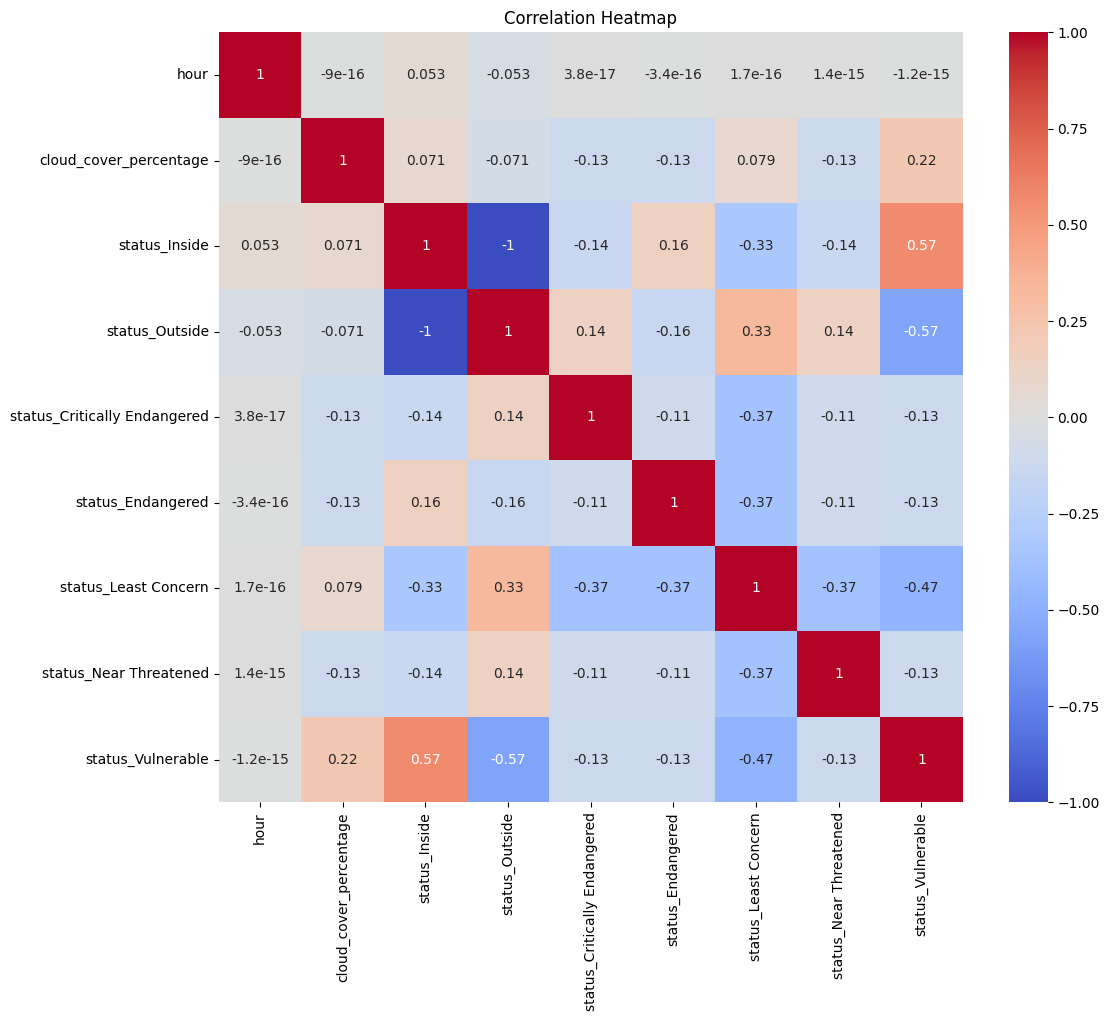

In [27]:

# Visualize crossings by time of day
plt.figure(figsize=(12, 10))



# Perform one hot encoding on the status of animals (whether they are inside protected territory or not)
tracking_satellites_gdf = pd.get_dummies(tracking_satellites_gdf, columns=['protected_area_status', 'redlist_cat'], prefix='status')

correlation_matrix = tracking_satellites_gdf[['hour', 'cloud_cover_percentage', 'status_Inside', 'status_Outside', 'status_Critically Endangered',
       'status_Endangered', 'status_Least Concern', 'status_Near Threatened',
       'status_Vulnerable' ]].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


The first noticing I have from the correlation matrix is that there is a decent correlation between whether or not an animal is inside protected territory and when they are vulnerable. If an animal is vulnerable, there is around .57 correlation of a vulnerable animal to cross into protected land. There is also a -.33 correlation status inside and status of least concern (regarding animal endangerment status).